# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

c:\Users\pmarc\.conda\envs\inteli_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset size: 12800
Image shape: torch.Size([1, 21, 21])


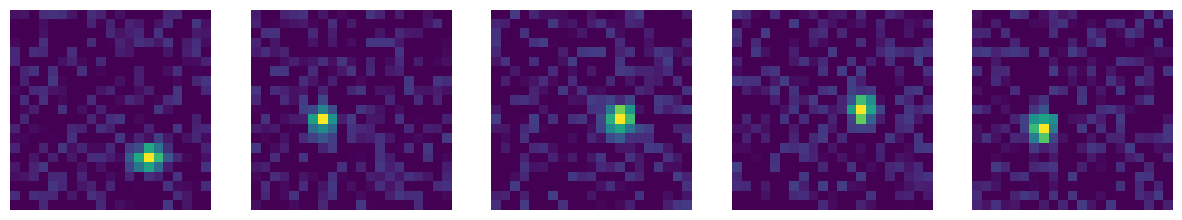

In [2]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.model.metrics as metrics
import src.model.train as train
import src.model.ae as ae
import src.model.gau as gaussian
import src.model.linear_probing as lp


# Dataset Setup

In [3]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')

In [4]:
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

Dataset size: 12800
Image shape: torch.Size([1, 21, 21])


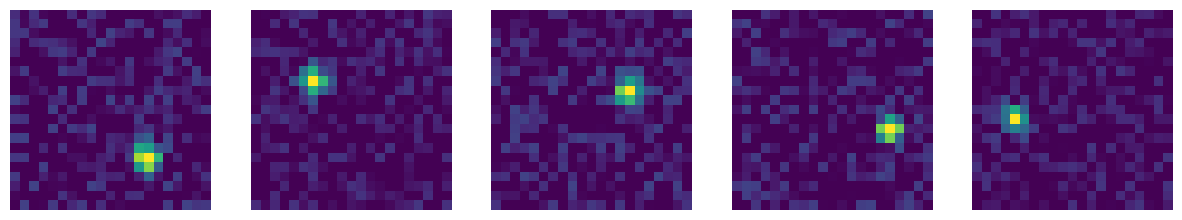

In [5]:
importlib.reload(gaussian)

# generate fake gaussian dataset
num_samples = 15000
image_size = 21
border_margin = 4
noise_level = 0.1
brightness = 0.7

gaussian_images = gaussian.generate_gaussian_dataset(num_samples, image_size, border_margin, noise_level, brightness)
gaussian_dataset = TensorDataset(gaussian_images)

### 5stamps_dataset (MODIFICAR PARA DUAL CHANNEL)

In [6]:
train_dataset_0 = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_dataset_0 = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_dataset_0 = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

#normalize between 0 and 1
train_difference = (train_dataset_0 - train_dataset_0.min()) / (train_dataset_0.max() - train_dataset_0.min())
validation_difference = (validation_dataset_0 - validation_dataset_0.min()) / (validation_dataset_0.max() - validation_dataset_0.min())
test_difference = (test_dataset_0 - test_dataset_0.min()) / (test_dataset_0.max() - test_dataset_0.min())

# Reshape the arrays to separate timestamps
num_samples, num_photos, height, width = train_difference.shape
reshaped_train_difference = train_difference.reshape(num_samples * num_photos, 1, height, width)
reshaped_train_class = train_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape
reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, 1, height, width)
reshaped_val_class = validation_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape
reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, 1, height, width)
reshaped_test_class = test_class_0.repeat_interleave(num_photos)

train_dataset_0 = TensorDataset(reshaped_train_difference, reshaped_train_class)
validation_dataset_0 = TensorDataset(reshaped_val_difference, reshaped_val_class)
test_dataset_0 = TensorDataset(reshaped_test_difference, reshaped_test_class)

### stamp_dataset_21_new

In [7]:
train_difference = torch.tensor(dataset_1_21['Train']['images'], dtype=torch.float32)
validation_difference = torch.tensor(dataset_1_21['Validation']['images'], dtype=torch.float32)
test_difference = torch.tensor(dataset_1_21['Test']['images'], dtype=torch.float32)

train_class_1 = torch.tensor(dataset_1_21['Train']['class'], dtype=torch.float32)
validation_class_1 = torch.tensor(dataset_1_21['Validation']['class'], dtype=torch.float32)
test_class_1 = torch.tensor(dataset_1_21['Test']['class'], dtype=torch.float32)

train_difference = (train_difference - train_difference.min()) / (train_difference.max() - train_difference.min())
validation_difference = (validation_difference - validation_difference.min()) / (validation_difference.max() - validation_difference.min())
test_difference = (test_difference - test_difference.min()) / (test_difference.max() - test_difference.min())


# Seleccionar los canales 0 y 2
train_difference_reshaped = train_difference[:, :, :, [0, 2]]
validation_difference_reshaped = validation_difference[:, :, :, [0, 2]]
test_difference_reshaped = test_difference[:, :, :, [0, 2]]

# Permutar las dimensiones para que tengan la forma [batch_size, num_channels, height, width]
train_difference_reshaped_perm = train_difference_reshaped.permute(0, 3, 1, 2)
validation_difference_reshaped_perm = validation_difference_reshaped.permute(0, 3, 1, 2)
test_difference_reshaped_perm = test_difference_reshaped.permute(0, 3, 1, 2)

train_dataset_1 = TensorDataset(train_difference_reshaped_perm, train_class_1)
validation_dataset_1 = TensorDataset(validation_difference_reshaped_perm, validation_class_1)
test_dataset_1 = TensorDataset(test_difference_reshaped_perm, test_class_1)

# Model Experiments

## Augmentation

In [14]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

#static parameters
max_epochs = 300
criterion = ae.loss_function
batch_size = 100 #100
lr = 0.333e-4 #propuesto en paper astorga

early_stopping = 15
use_gpu = True

model_1_1 = ae.AE(latent_dim = 30, n_channels=2, name='with no augmentation')
model_1_2 = ae.AE(latent_dim = 30, n_channels=2, name='with augmentation')
model_1_3 = ae.AE(latent_dim = 30, n_channels=2, name='with augmentation and shuffling')

curves_1_1, tiempo_1_1, mse_1_1 = train.train_model(model_1_1,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=False,
                                            shuffle_augmentation=False,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_1_2, tiempo_1_2, mse_1_2 = train.train_model(model_1_2,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=True,
                                            shuffle_augmentation=False,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_1_3, tiempo_1_3, mse_1_3 = train.train_model(model_1_3,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=True,
                                            shuffle_augmentation=True,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model_1_1.state_dict(), 'models/model_1_1.pth')
torch.save(model_1_2.state_dict(), 'models/model_1_2.pth')
torch.save(model_1_3.state_dict(), 'models/model_1_3.pth')

curves_1 = [curves_1_1, curves_1_2, curves_1_3]
models_1 = [model_1_1, model_1_2, model_1_3]
mse_1 = [mse_1_1, mse_1_2, mse_1_3]

Starting training ...
Epoch 128/300 (Early Stop) -- Iteration 93184 - Batch 727/728 - Train loss: 0.00323823 - Val loss: 0.00227273Tiempo total de entrenamiento: 806.88 [s]

Augmenting Data ... 
Starting training ...
Epoch 167/300 (Early Stop) -- Iteration 728621 - Batch 4362/4363 - Train loss: 0.00222961 - Val loss: 0.00211766Tiempo total de entrenamiento: 5849.09 [s]

Augmenting Data ... 
Starting training ...
Epoch 220/300 (Early Stop) -- Iteration 1119800 - Batch 5089/5090 - Train loss: 0.00296182 - Val loss: 0.00208909Tiempo total de entrenamiento: 8932.81 [s]



## Latent dimensions

In [ ]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

#static parameters
max_epochs = 300
criterion = ae.loss_function
batch_size = 100 #100
lr = 0.333e-4 #propuesto en paper astorga

augmentation = True
suffle = False
early_stopping = 15
use_gpu = True

model_2_1 = ae.AE(latent_dim = 10, n_channels=2, name='latent dim 10')
model_2_2 = ae.AE(latent_dim = 21, n_channels=2, name='latent dim 21')
model_2_3 = ae.AE(latent_dim = 42, n_channels=2, name='latent dim 42')
model_2_4 = ae.AE(latent_dim = 130, n_channels=2, name='latent dim 130')


curves_2_1, tiempo_2_1, mse_2_1 = train.train_model(model_2_1,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_2_2, tiempo_2_2, mse_2_2 = train.train_model(model_2_2,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_2_3, tiempo_2_3, mse_2_3 = train.train_model(model_2_3,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_2_4, tiempo_2_4, mse_2_4 = train.train_model(model_2_4,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model_2_1.state_dict(), 'models/model_2_1.pth')
torch.save(model_2_2.state_dict(), 'models/model_2_2.pth')
torch.save(model_2_3.state_dict(), 'models/model_2_3.pth')
torch.save(model_2_4.state_dict(), 'models/model_2_4.pth')

curves_2 = [curves_2_1, curves_2_2, curves_2_3, curves_2_4]
models_2 = [model_2_1, model_2_2, model_2_3, model_2_4]
mse_2 = [mse_2_1, mse_2_2, mse_2_3, mse_2_4]

Augmenting Data ... 


## Learning Rate

In [ ]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

#static parameters
max_epochs = 300
criterion = ae.loss_function
batch_size = 100 #100

augmentation = True
suffle = False
early_stopping = 15
use_gpu = True

model_3_1 = ae.AE(latent_dim = 'definir', n_channels=2, name='with lr 0.333e-4')
model_3_2 = ae.AE(latent_dim = 'definir', n_channels=2, name='latent dim 21')
model_3_3 = ae.AE(latent_dim = 'definir', n_channels=2, name='latent dim 42')
model_3_4 = ae.AE(latent_dim = 'definir', n_channels=2, name='latent dim 130')


curves_3_1, tiempo_3_1, mse_3_1 = train.train_model(model_3_1,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=0.333e-4,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_3_2, tiempo_3_2, mse_3_2 = train.train_model(model_3_2,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=0.333e-5,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_3_3, tiempo_3_3, mse_3_3 = train.train_model(model_3_3,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=0.333e-3,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model_3_1.state_dict(), 'models/model_3_1.pth')
torch.save(model_3_2.state_dict(), 'models/model_3_2.pth')
torch.save(model_3_3.state_dict(), 'models/model_3_3.pth')

curves_3 = [curves_3_1, curves_3_2, curves_3_3]
models_3 = [model_3_1, model_3_2, model_3_3]
mse_3 = [mse_3_1, mse_3_2, mse_3_3]

## Datasets

In [ ]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

#static parameters
max_epochs = 300
criterion = ae.loss_function
batch_size = 100 #100
lr = 0.333e-4 #propuesto en paper astorga

augmentation = True
suffle = False
early_stopping = 15
use_gpu = True

model_4_1 = ae.AE(latent_dim = 'definir', n_channels=2, name='trained with 5stamps_dataset')
model_4_2 = ae.AE(latent_dim = 'definir', n_channels=2, name='trained with stamp_dataset_21_new')


curves_4_1, tiempo_4_1, mse_4_1 = train.train_model(model_4_1,
                                            train_dataset_0,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

curves_4_2, tiempo_4_2, mse_4_2 = train.train_model(model_4_2,
                                            train_dataset_1,
                                            validation_dataset_1,
                                            test_dataset_1,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model_4_1.state_dict(), 'models/model_4_1.pth')
torch.save(model_4_2.state_dict(), 'models/model_4_2.pth')

curves_4 = [curves_4_1, curves_4_2]
models_4 = [model_4_1, model_4_2]
mse_4 = [mse_4_1, mse_4_2]

# Linear Probing Training

In [ ]:
# linear probing settings
lp_epochs = 200
lp_criterion = nn.CrossEntropyLoss()
lp_batch_size = 100
lp_lr = 0.333e-4
use_gpu = True

In [ ]:
importlib.reload(lp)

train_1, val_1, test_1 = lp.get_latent_features(models_1, train_dataset_1, validation_dataset_1, test_dataset_1)

lp_model_1_1 = lp.LinearClassifier('30', 5)
lp_model_1_2 = lp.LinearClassifier('30', 5)
lp_model_1_3 = lp.LinearClassifier('30', 5)

lp_curves_1_1, lp_tiempo_1_1, lp_labels_1_1, lp_pred_1_1 = lp.train_model(lp_model_1_1, train_1[0], val_1[0], test_1[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_1_2, lp_tiempo_1_2, lp_labels_1_2, lp_pred_1_2 = lp.train_model(lp_model_1_2, train_1[1], val_1[1], test_1[1], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_1_3, lp_tiempo_1_3, lp_labels_1_3, lp_pred_1_3 = lp.train_model(lp_model_1_3, train_1[2], val_1[2], test_1[2], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

matrix_1 = [confusion_matrix(lp_labels_1_1, lp_pred_1_1), confusion_matrix(lp_labels_1_2, lp_pred_1_2), confusion_matrix(lp_labels_1_3, lp_pred_1_3)]

In [ ]:
importlib.reload(lp)

train_2, val_2, test_2 = lp.get_latent_features(models_2, train_dataset_1, validation_dataset_1, test_dataset_1)

lp_model_2_1 = lp.LinearClassifier('30', 5)
lp_model_2_2 = lp.LinearClassifier('30', 5)
lp_model_2_3 = lp.LinearClassifier('30', 5)
lp_model_2_4 = lp.LinearClassifier('30', 5)

lp_curves_2_1, lp_tiempo_2_1, lp_labels_2_1, lp_pred_2_1 = lp.train_model(lp_model_2_1, train_2[0], val_2[0], test_2[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_2_2, lp_tiempo_2_2, lp_labels_2_2, lp_pred_2_2 = lp.train_model(lp_model_2_2, train_2[1], val_2[1], test_2[1], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_2_3, lp_tiempo_2_3, lp_labels_2_3, lp_pred_2_3 = lp.train_model(lp_model_2_3, train_2[2], val_2[2], test_2[2], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_2_4, lp_tiempo_2_4, lp_labels_2_4, lp_pred_2_4 = lp.train_model(lp_model_2_4, train_2[3], val_2[3], test_2[3], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

matrix_2 = [confusion_matrix(lp_labels_2_1, lp_pred_2_1), confusion_matrix(lp_labels_2_2, lp_pred_2_2), confusion_matrix(lp_labels_2_3, lp_pred_2_3), confusion_matrix(lp_labels_2_4, lp_pred_2_4)]

In [ ]:
importlib.reload(lp)

train_3, val_3, test_3 = lp.get_latent_features(models_3, train_dataset_1, validation_dataset_1, test_dataset_1)

lp_model_3_1 = lp.LinearClassifier('30', 5)
lp_model_3_2 = lp.LinearClassifier('30', 5)
lp_model_3_3 = lp.LinearClassifier('30', 5)

lp_curves_3_1, lp_tiempo_3_1, lp_labels_3_1, lp_pred_3_1 = lp.train_model(lp_model_3_1, train_3[0], val_3[0], test_3[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_3_2, lp_tiempo_3_2, lp_labels_3_2, lp_pred_3_2 = lp.train_model(lp_model_3_2, train_3[1], val_3[1], test_3[1], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_3_3, lp_tiempo_3_3, lp_labels_3_3, lp_pred_3_3 = lp.train_model(lp_model_3_3, train_3[2], val_3[2], test_3[2], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

matrix_3 = [confusion_matrix(lp_labels_3_1, lp_pred_3_1), confusion_matrix(lp_labels_3_2, lp_pred_3_2), confusion_matrix(lp_labels_3_3, lp_pred_3_3)]

In [ ]:
importlib.reload(lp)

train_4_1, val_4_1, test_4_1 = lp.get_latent_features([models_4[0]], train_dataset_0, validation_dataset_0, test_dataset_0)
train_4_2, val_4_2, test_4_2 = lp.get_latent_features([models_4[1]], train_dataset_1, validation_dataset_1, test_dataset_1)

lp_model_4_1 = lp.LinearClassifier('30', 3)
lp_model_4_2 = lp.LinearClassifier('30', 5)

lp_curves_4_1, lp_tiempo_4_1, lp_labels_4_1, lp_pred_4_1 = lp.train_model(lp_model_4_1, train_4_1[0], val_4_1[0], test_4_1[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_4_2, lp_tiempo_4_2, lp_labels_4_2, lp_pred_4_2 = lp.train_model(lp_model_4_2, train_4_2[0], val_4_2[0], test_4_2[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

matrix_4 = [confusion_matrix(lp_labels_4_1, lp_pred_4_1), confusion_matrix(lp_labels_4_2, lp_pred_4_2)]

# Metrics

In [ ]:
# settings

#umap 
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
norm = True

## Augmentation

In [11]:
# learning curves + mse
metrics.show_curves(curves_1, models_1)


In [12]:
# latent space umap
metrics.plot_umap(models_1, test_dataset_1, test_class_1, n_neighbors, min_dist, metric, norm)

In [ ]:
# linear probing umap + confusion matrix
metrics.plot_matrix(models_1, matrix_1)

In [ ]:
# reconstruction examples

## Latent dimensions

In [ ]:
# learning curves + mse
metrics.show_curves(curves_2, models_2)

In [ ]:
# latent space umap
metrics.plot_umap(models_2, test_dataset_1, test_class_1, n_neighbors, min_dist, metric, norm)

In [ ]:
# linear probing umap + confusion matrix
metrics.plot_matrix(models_2, matrix_2)

In [ ]:
# reconstruction examples

## Learning rate

In [ ]:
# learning curves + mse
metrics.show_curves(curves_3, models_3)

In [13]:
# latent space umap
metrics.plot_umap(models_3, test_dataset_1, test_class_1, n_neighbors, min_dist, metric, norm)

In [ ]:
# linear probing umap + confusion matrix
metrics.plot_matrix(models_3, matrix_3)

In [ ]:
# reconstruction examples

## Datasets

In [ ]:
# learning curves + mse
metrics.show_curves(curves_4, models_4)

In [ ]:
# latent space umap
metrics.plot_umap(models_4, test_dataset_0, test_class_0, n_neighbors, min_dist, metric, norm)
metrics.plot_umap(models_4, test_dataset_1, test_class_1, n_neighbors, min_dist, metric, norm)

In [ ]:
# linear probing umap + confusion matrix
metrics.plot_matrix(models_4, matrix_4)

In [ ]:
# reconstruction examples